In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import sourmash
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

## Read in signatures

In [3]:
sigfile = "astral-scopedom-seqres-gd-sel-gs-bib-40-2.08.hp.k24.sig.zip"


Bug in `load_file_as_signatures`

```
---------------------------------------------------------------------------
Panic                                     Traceback (most recent call last)
Cell In[5], line 1
----> 1 sigs = sourmash.load_file_as_signatures(sigfile)

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/sourmash_args.py:797, in load_file_as_signatures(filename, select_moltype, ksize, picklist, yield_all_files, progress, pattern, _use_manifest)
    794 if progress:
    795     progress.notify(filename)
--> 797 db = _load_database(filename, yield_all_files)
    799 # test fixture ;)
    800 if not _use_manifest and db.manifest:

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/save_load.py:117, in _load_database(filename, traverse_yield_all, cache_size)
    113 try:
    114     debug_literal(
    115         f"_load_databases: trying loader fn - priority {priority} - '{desc}'"
    116     )
--> 117     db = load_fn(
    118         filename, traverse_yield_all=traverse_yield_all, cache_size=cache_size
    119     )
    120 except (ValueError, IndexNotLoaded):
    121     debug_literal(f"_load_databases: FAIL with ValueError: on fn {desc}.")

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/save_load.py:198, in _load_sbt(filename, **kwargs)
    195 cache_size = kwargs.get("cache_size")
    197 try:
--> 198     db = load_sbt_index(filename, cache_size=cache_size)
    199 except (FileNotFoundError, TypeError) as exc:
    200     raise IndexNotLoaded(exc)

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/sbtmh.py:10, in load_sbt_index(filename, print_version_warning, cache_size)
      8 def load_sbt_index(filename, *, print_version_warning=True, cache_size=None):
      9     "Load and return an SBT index."
---> 10     return SBT.load(
     11         filename,
     12         leaf_loader=SigLeaf.load,
     13         print_version_warning=print_version_warning,
     14         cache_size=cache_size,
     15     )

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/sbt.py:855, in SBT.load(cls, location, leaf_loader, storage, print_version_warning, cache_size)
    853 if storage is None:
    854     if ZipStorage.can_open(location):
--> 855         storage = ZipStorage(location)
    856     else:
    857         if not location.endswith(".sbt.zip"):

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/sbt_storage.py:105, in ZipStorage.__init__(self, path, mode)
    103 self.__inner = None
    104 path = os.path.abspath(path)
--> 105 self._objptr = rustcall(lib.zipstorage_new, to_bytes(path), len(path))

File ~/miniconda3/envs/2024-sourmash-branchwater-tf-idf/lib/python3.12/site-packages/sourmash/utils.py:78, in rustcall(func, *args)
     76 if backtrace:
     77     exc.rust_info = backtrace
---> 78 raise exc

Panic: sourmash panicked: thread 'unnamed' panicked with 'called `Result::unwrap()` on an `Err` value: InvalidArchive("Too small for anything but End Of Central Directory Record")' at src/core/src/storage/mod.rs:390
```

In [4]:
def make_hashval_series(sig):
    hashes = pd.Series(sig.minhash.get_mins(with_abundance=True), name=sig.name)
    return hashes

In [5]:
# sigs = list(sourmash.load_file_as_signatures(sigfile, select_moltype="hp", ksize=24))
sigs = sourmash.load_file_as_signatures(sigfile, select_moltype="hp", ksize=24)
# len(sigs)

hashval_seriess = [make_hashval_series(sig) for sig in sigs]
len(hashval_seriess)
hashval_seriess[0]

/tmp/ipykernel_1029785/948154211.py:2: DeprecatedWarning: get_mins is deprecated as of 3.5 and will be removed in 5.0. Use .hashes property instead.
  hashes = pd.Series(sig.minhash.get_mins(with_abundance=True), name=sig.name)


14325941771346195       1
251954434282757395      1
685073878297355046      1
730036929072272423      1
801358951035248431      1
                       ..
17788885969502232507    1
17816509737006047909    1
17996627387480003578    1
18032909882882529161    1
18390883954701535221    1
Name: d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]}, Length: 93, dtype: int64

In [6]:
corpus = [
    " ".join(f"{hashval}" * abund for hashval, abund in hashval_abund.items())
    for hashval_abund in hashval_seriess
]
len(corpus)

15177

In [12]:
# %%time

# hashval_df = pd.concat(hashval_seriess, axis=1)
# print(hashval_df.shape)
# hashval_df.head()

In [13]:
names = [x.name for x in hashval_seriess]
print(len(names))
names[0]

15177


'd1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]}'

In [14]:
titin_names = [x for x in names if "Titin" in x]
titin_names

['d3qp3a1 b.1.1.4 (A:2-101) Titin {Human (Homo sapiens), different modules [TaxId: 9606]}',
 'd1g1ca_ b.1.1.4 (A:) Titin {Human (Homo sapiens), different modules [TaxId: 9606]}',
 'd1ncua1 b.1.1.4 (A:-5-91) Titin {Human (Homo sapiens), different modules [TaxId: 9606]}',
 'd1tkia_ d.144.1.7 (A:) Titin, kinase domain {Human (Homo sapiens) [TaxId: 9606]}']

## Use scikit-learn Counts Vectorizer

In [15]:
%%time

count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(corpus)
X_counts

CPU times: user 7.12 s, sys: 240 ms, total: 7.36 s
Wall time: 7.35 s


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2455075 stored elements and shape (15177, 2246789)>

In [16]:
X_counts.sum(axis=1)

matrix([[ 93],
        [104],
        [103],
        ...,
        [ 67],
        [108],
        [ 67]])

### Get the L1 norm, aka the frequencies

In [17]:
X_l1_freqs = normalize(X_counts, norm="l1")
X_l1_freqs

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2455075 stored elements and shape (15177, 2246789)>

### Get the L2 norm, aka the frequencies

In [18]:
X_l2_norm = normalize(X_counts, norm="l2")
X_l2_norm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2455075 stored elements and shape (15177, 2246789)>

# TF-IDF


## Test different metrics

In [19]:
kwargs = {
    "defaults_norm_l2_yes_smoothing": {},
    "norm_l2_no_smoothing": dict(norm="l2", smooth_idf=False),
    "norm_l1_yes_smoothing": dict(norm="l1"),
    # This is what I was originally using
    "norm_l1_no_smoothing_original": dict(norm="l1", smooth_idf=False),
}

similarities = {}


for name, kw in kwargs.items():

    vectorizer = TfidfVectorizer(**kw)
    X = vectorizer.fit_transform(corpus)
    print(f"--- {name} ---")
    sim = cosine_similarity(X, X)
    sim_df = pd.DataFrame(sim, index=names, columns=names)
    similarities[name] = sim_df
    break
    # print(query_frequencies.apply(lambda x: (x * vectorizer.idf_).sum()))

--- defaults_norm_l2_yes_smoothing ---


In [20]:
sim_df

,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]},"d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbN [TaxId: 1773]}","d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbO [TaxId: 1773]}",d2bkma_ a.1.1.1 (A:) automated matches {Geobacillus stearothermophilus [TaxId: 1422]},d4i0va_ a.1.1.1 (A:) automated matches {Synechococcus sp. [TaxId: 32049]},"d1asha_ a.1.1.2 (A:) Ascaris hemoglobin, domain 1 {Pig roundworm (Ascaris suum) [TaxId: 6253]}",d2dc3a_ a.1.1.2 (A:) Cytoglobin {Human (Homo sapiens) [TaxId: 9606]},d4hswa_ a.1.1.2 (A:) Dehaloperoxidase {Amphitrite ornata [TaxId: 129555]},"d1ecaa_ a.1.1.2 (A:) Erythrocruorin {Midge (Chironomus thummi thummi), fraction III [TaxId: 7154]}","d1x9fd_ a.1.1.2 (D:) Extracellular dodecameric hemoglobin (erythrocruorin), subunit D1 {Common earthworm (Lumbricus terrestris) [TaxId: 6398]}",...,d3pt6a1 g.95.1.1 (A:651-700) Zn finger domain from DNA methyltransferase 1 (DNMT1) {Mouse (Mus musculus) [TaxId: 10090]},d2foma1 g.96.1.1 (A:49-95) Flavivirus non-structural protein NS2B {Dengue virus 2 [TaxId: 11060]},d6y3ba_ g.96.1.0 (A:) automated matches {Zika virus [TaxId: 64320]},d3s2ra_ g.97.1.0 (A:) automated matches {Thale cress (Arabidopsis thaliana) [TaxId: 3702]},d4c3hd_ g.98.1.1 (D:) RNA polymerase I subunit A14 {Baker's yeast (Saccharomyces cerevisiae) [TaxId: 4932]},d6id0n_ g.99.1.1 (N:) automated matches {Human (Homo sapiens) [TaxId: 9606]},"d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing factor Cwf5 / Ecm2 / Stl11, Zn-binding domain {Baker's yeast (Saccharomyces cerevisiae) [TaxId: 4932]}",d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor Phf5 / Rds3 {Human (Homo sapiens) [TaxId: 9606]},d5fyza2 g.102.1.0 (A:623-753) automated matches {Human (Homo sapiens) [TaxId: 9606]},"d4g26a2 g.103.1.1 (A:300-352,A:535-570) Proteinaceous RNAse P1 (PRORP1) {Thale cress (Arabidopsis thaliana) [TaxId: 3702]}"
d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]},1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbN [TaxId: 1773]}",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbO [TaxId: 1773]}",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d2bkma_ a.1.1.1 (A:) automated matches {Geobacillus stearothermophilus [TaxId: 1422]},0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d4i0va_ a.1.1.1 (A:) automated matches {Synechococcus sp. [TaxId: 32049]},0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d6id0n_ g.99.1.1 (N:) automated matches {Human (Homo sapiens) [TaxId: 9606]},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing factor Cwf5 / Ecm2 / Stl11, Zn-binding domain {Baker's yeast (Saccharomyces cerevisiae) [TaxId: 4932]}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor Phf5 / Rds3 {Human (Homo sapiens) [TaxId: 9606]},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
d5fyza2 g.102.1.0 (A:623-753) automated matches {Human (Homo sapiens) [TaxId: 9606]},0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# sns.displot(sim_df[sim_df > 0].values.flatten())

## Make feature vectors

In [22]:
lineages = pd.Series(
    [x.split()[1] for x in names], index=names, name="full_lineage"
).to_frame()
# lineages['protein'] = lineages.full_lineage.split('\.')
lineages.full_lineage.value_counts()

full_lineage
c.2.1.0     196
c.94.1.0    132
b.1.1.0     127
c.47.1.0    121
c.37.1.0    109
           ... 
g.78.1.1      1
g.82.1.1      1
a.4.1.13      1
a.4.1.14      1
a.4.1.15      1
Name: count, Length: 4703, dtype: int64

### Use regex to extract family information

https://regex101.com/r/gKBJAr/1

In [23]:
pattern = r"(?P<family>(?P<superfamily>(?P<fold>(?P<class>[a-z])\.\d+)\.\d+)\.\d+)"
lineages_extracted = lineages.full_lineage.str.extractall(pattern)
lineages_extracted = lineages_extracted.droplevel(-1)
lineages_extracted.head()

,family,superfamily,fold,class
d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]},a.1.1.1,a.1.1,a.1,a
"d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbN [TaxId: 1773]}",a.1.1.1,a.1.1,a.1,a
"d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbO [TaxId: 1773]}",a.1.1.1,a.1.1,a.1,a
d2bkma_ a.1.1.1 (A:) automated matches {Geobacillus stearothermophilus [TaxId: 1422]},a.1.1.1,a.1.1,a.1,a
d4i0va_ a.1.1.1 (A:) automated matches {Synechococcus sp. [TaxId: 32049]},a.1.1.1,a.1.1,a.1,a


In [24]:
lineages_metadata = pd.concat([lineages, lineages_extracted], axis=1)
lineages_metadata.head()

,full_lineage,family,superfamily,fold,class
d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Ciliate (Paramecium caudatum) [TaxId: 5885]},a.1.1.1,a.1.1.1,a.1.1,a.1,a
"d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbN [TaxId: 1773]}",a.1.1.1,a.1.1.1,a.1.1,a.1,a
"d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemoglobin {Mycobacterium tuberculosis, HbO [TaxId: 1773]}",a.1.1.1,a.1.1.1,a.1.1,a.1,a
d2bkma_ a.1.1.1 (A:) automated matches {Geobacillus stearothermophilus [TaxId: 1422]},a.1.1.1,a.1.1.1,a.1.1,a.1,a
d4i0va_ a.1.1.1 (A:) automated matches {Synechococcus sp. [TaxId: 32049]},a.1.1.1,a.1.1.1,a.1.1,a.1,a


In [25]:
target_names = ["class", "fold", "superfamily", "family"]

In [37]:
with warnings.catch_warnings(action="ignore"):
    mean_similarity = sim_df.groupby(lineages_extracted["class"]).apply(
        lambda x: x.groupby(lineages_extracted["class"], axis=1).mean()
    )
mean_similarity

class                                                            a         b  \
class                                                                          
a     d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000381  0.000016   
      d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000384  0.000008   
      d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000385  0.000003   
      d2bkma_ a.1.1.1 (A:) automated matches {Geobaci...  0.000380  0.000000   
      d4i0va_ a.1.1.1 (A:) automated matches {Synecho...  0.000382  0.000005   
...                                                            ...       ...   
g     d6id0n_ g.99.1.1 (N:) automated matches {Human ...  0.000018  0.000003   
      d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing f...  0.000009  0.000008   
      d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor...  0.000007  0.000000   
      d5fyza2 g.102.1.0 (A:623-753) automated matches...  0.000002  0.000000   
      d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protein...  0.000000  0.000000   

class                                                                c  \
class                                                                    
a     d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  4.663308e-06   
      d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  1.660158e-05   
      d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  1.754925e-05   
      d2bkma_ a.1.1.1 (A:) automated matches {Geobaci...  2.155069e-05   
      d4i0va_ a.1.1.1 (A:) automated matches {Synecho...  5.081307e-06   
...                                                                ...   
g     d6id0n_ g.99.1.1 (N:) automated matches {Human ...  3.708277e-06   
      d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing f...  3.912778e-06   
      d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor...  1.300971e-05   
      d5fyza2 g.102.1.0 (A:623-753) automated matches...  8.797407e-07   
      d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protein...  1.305463e-05   

class                                                            d         e  \
class                                                                          
a     d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000020  0.000000   
      d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000026  0.000000   
      d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000002  0.000016   
      d2bkma_ a.1.1.1 (A:) automated matches {Geobaci...  0.000020  0.000000   
      d4i0va_ a.1.1.1 (A:) automated matches {Synecho...  0.000001  0.000000   
...                                                            ...       ...   
g     d6id0n_ g.99.1.1 (N:) automated matches {Human ...  0.000008  0.000000   
      d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing f...  0.000000  0.000000   
      d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor...  0.000017  0.000000   
      d5fyza2 g.102.1.0 (A:623-753) automated matches...  0.000002  0.000000   
      d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protein...  0.000009  0.000000   

class                                                            f         g  
class                                                                         
a     d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000000  0.000000  
      d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000133  0.000000  
      d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemogl...  0.000000  0.000000  
      d2bkma_ a.1.1.1 (A:) automated matches {Geobaci...  0.000000  0.000000  
      d4i0va_ a.1.1.1 (A:) automated matches {Synecho...  0.000028  0.000000  
...                                                            ...       ...  
g     d6id0n_ g.99.1.1 (N:) automated matches {Human ...  0.000000  0.001385  
      d5lj3n2 g.100.1.1 (N:6-144) Pre-mRNA splicing f...  0.000010  0.001385  
      d5syba_ g.101.1.1 (A:) Pre-mRNA splicing factor...  0.000000  0.001385  
      d5fyza2 g.102.1.0 (A:623-753) automated matches...  0.000000  0.001385  
      d

In [46]:
stacked = mean_similarity.stack()
stacked.name = "mean_similarity"
# stacked.index

stacked.index.names = ["class_self", "sample_name", "class_other"]

similarity_tidy = stacked.reset_index()
similarity_tidy

,class_self,sample_name,class_other,mean_similarity
0,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,0.000381
1,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,b,0.000016
2,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,c,0.000005
3,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,d,0.000020
4,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,e,0.000000
...,...,...,...,...
106234,g,"d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protei...",c,0.000013
106235,g,"d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protei...",d,0.000009
106236,g,"d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protei...",e,0.000000
106237,g,"d4g26a2 g.103.1.1 (A:300-352,A:535-570) Protei...",f,0.000000


In [47]:
similarity_tidy["same_class"] = (
    similarity_tidy["class_other"] == similarity_tidy["class_self"]
)

In [59]:
# sns.violinplot?

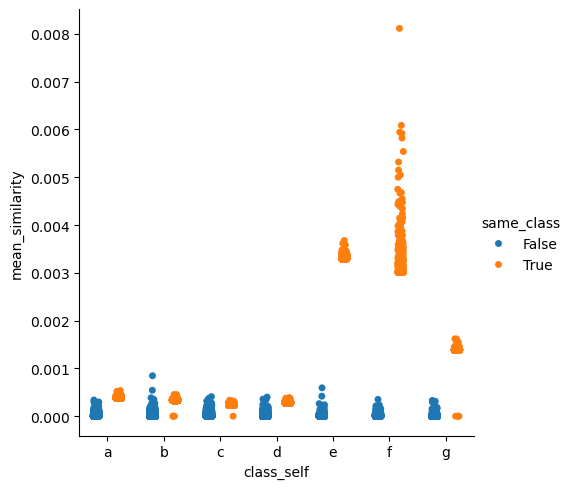

In [65]:
sns.catplot(
    data=similarity_tidy,
    x="class_self",
    hue="same_class",
    y="mean_similarity",
    dodge=True,
    # kind="violin",
    # split=True,
    # aspect=2,
)

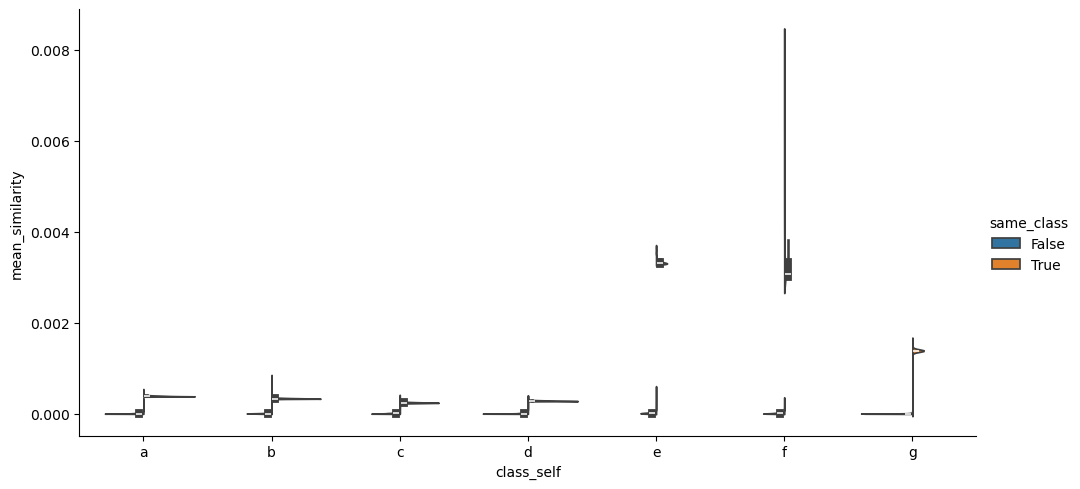

In [56]:
sns.catplot(
    data=similarity_tidy,
    x="class_self",
    hue="same_class",
    y="mean_similarity",
    kind="violin",
    split=True,
    aspect=2,
)

### Run on all the lienages

In [ ]:
import warnings


def compute_mean_similarity(similarity_df, groupby):
    with warnings.catch_warnings(action="ignore"):
        mean_similarity = similarity_df.groupby(groupby).apply(
            lambda x: x.groupby(groupby, axis=1).mean()
        )
    return mean_similarity


def tidify_similarity(mean_similarity):
    stacked = mean_similarity.stack()
    stacked.name = "mean_similarity"
    # stacked.index

    names = stacked.index.names
    lineage_level = names[0]

    stacked.index.names = ["lineage_self", "sample_name", "lineage_other"]

    similarity_tidy = stacked.reset_index()
    similarity_tidy["lineage_level"] = lineage_level
    similarity_tidy[f"same_lineage"] = (
        similarity_tidy['lineage_self'] == similarity_tidy['lineage_other']
    )

    return similarity_tidy


def get_tidy_lineage_similiarity(sim_df, lineage_level, lineages_extracted=lineages_extracted):
    mean_similarity = compute_mean_similarity(sim_df, lineages_extracted[lineage_level])
    similarity_tidy = tidify_similarity(mean_similarity)
    return similarity_tidy

lineage_levels = target_names = ["class", "fold", "superfamily", "family"]



dfs = []

for lineage_level in lineage_levels:
    print(f'--- {lineage_level} ---')
    df = get_tidy_lineage_similiarity(sim_df, lineage_level)
    dfs.append(df)
    print(df.shape)
    display(df.head())
tidy_sim_df = pd.concat(dfs)
print(tidy_sim_df.shape)
tidy_sim_df.head()

--- class ---


,lineage_self,sample_name,lineage_other,mean_similarity,lineage_level,same_lineage
0,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,0.000381,class,True
1,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,b,0.000016,class,False
2,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,c,0.000005,class,False
3,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,d,0.000020,class,False
4,a,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,e,0.000000,class,False


--- fold ---


,lineage_self,sample_name,lineage_other,mean_similarity,lineage_level,same_lineage
0,a.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.1,0.016129,fold,True
1,a.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.10,0.000000,fold,False
2,a.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.100,0.000000,fold,False
3,a.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.101,0.000000,fold,False
4,a.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.102,0.000000,fold,False


--- superfamily ---


,lineage_self,sample_name,lineage_other,mean_similarity,lineage_level,same_lineage
0,a.1.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.1.1,0.017544,superfamily,True
1,a.1.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.1.2,0.000000,superfamily,False
2,a.1.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.10.1,0.000000,superfamily,False
3,a.1.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.10.2,0.000000,superfamily,False
4,a.1.1,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a.100.1,0.000000,superfamily,False


--- family ---


In [61]:
# lineages_extracted.apply(lambda x: sim_df.groupby(x).mean())

## Try regression

In [48]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, lineages_metadata["family"])

In [53]:
# clf = LogisticRegression()
# clf.fit(X_train, y_train)